# Name: Chloe Wohlgemuth
### COSC247
### Ensembles

## Assignment Instructions
Use k-fold cross-validation to compare the performance of at least three different individual classification models, defined with pipelines, and an ensemble that is composed of those models. Then train all of the individual models and the ensemble on the full training set, and assess the performance of the trained models and the ensemble on the testing set.

You can start with the notebook presented in class on October 13, which meets all of the requirements spelled out below, or you can build your notebook from scratch, which will be more challenging but also more instructive. In either case, your notebook must differ from the notebook presented in class in at least the following ways:

You must use a different dataset. As in the Linear Classifiers assignment, the dataset that you use must include at least 500 instances. You may use the same dataset as a fellow student, as long as you don't use the same dataset and the same models as anyone else, as far as you know. You should include your dataset with your submission, unless it is included in scikit-learn.

You must change at least one of the individual model types. It is okay for more than one of your models to be of the same type, with different parameters.

You are encouraged to experiment with other changes as well. For example, you might want to change the ensemble method, from majority voting to something else such as bagging or boosting, although this is not a requirement. You might also want to change the cross-validation scoring metric, or the performance metric(s) used to assess your models on the testing set. You should be guided in these and other choices by the nature of the data and the problem that you are addressing, along with the performance that you see as you experiment with models.

For this assignment you can perform binary classification or multiclass classification.

Your notebook should perform at least the following steps:

- Read in your data.
- Divide the data into training and testing sets.
- Create pipelines for each of the classifiers, including whatever feature transformers you wish to apply.
- Create an ensemble, using all of the defined pipelines.
- Perform k-fold cross-validation to assess the performance of all pipelines and the ensemble.
- Individually train each of the pipelines and the ensemble on the full training set, and show the performance of each on the testing set.

Include the following information in markdown cells in your notebook:
- A description of the data that you are using
- A description of classification task that you are training your models to perform
- Descriptions of the models used in each of your pipelines, including any feature transformers
- A description of the ensemble method that you are using
- A summary of the results of cross-validation
- A summary of the results of testing on the testing data, including whether or not these results are consistent with those of cross-validation

You are encouraged to collaborate with classmates in completing this assignment, but you should acknowledge all help that you have received in your notebook file.

You can assume that your code will be run in a Python 3.8 environment in which numpy, matplotlib, pandas, and scikit-learn have been installed. Do not assume or require the installation of any other libraries.

Your should submit your notebook (.ipynb) file, your data file (probably a .csv file), and any other files that your code requires.

## Dataset Info
This is a dataset that consists of various features of NASA confirmed planets. The pertinent ones are:
* Orbital Period [days]
* Planet Mass or M*sin(i) [Jupiter mass]

#### Source
Data was produced by the NASA Exoplanet Archive: http://exoplanetarchive.ipac.caltech.edu
* Confirmed planets --> https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=planets
* Downloaded the table as a CSV file --> My file name: planets_2020.09.03_20.35.38.csv
* BUT, for ease of filename usage, I renamed to: planets090320.csv

## Purpose
The purpose in studying this dataset is to classify and compare planetary systems, specifically with regards to their quantitative properties. Plotting these properties can provide insight on the interactions and correlations between them. 

We do this by training an Support Vector Machine (SVM), Decision tree, and K-Nearest-Neighbors (KNN) model to classify between Jupiter-mass planets (class J) and Earth-mass planets (class E) based on mass and orbital period. Our ensemble method is majority voting. A (majority) voting ensemble is an ensemble ML model that combines predictions from multiple other models. For classification, the predictions for each label are summed and the label with majority vote is predicted.
- SVM: a set of supervised learning methods used for classification (here), regression and outliers detection
    - Feature Transformer(s): standard scaling - standardize features by removing the mean and scaling to unit variance
- Decision tree: non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features
- KNN: stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions)
    - Feature Transformer(s): standard scaling - standardize features by removing the mean and scaling to unit variance

We will compare the performance of the different models in their classification of these planets. This can be an important task because of the different properties, compositions, behaviors, etc. of different classes of planets. This has effects on their motion, aging, reactions (chemical, atmospheric, etc), interactions with space and bodies around them, etc. Our very understanding of the universe can be based on our studies of the different celestial bodies. 

## Helpful Background Info / Assumptions
* (EXCLUDED) Super-Jupiters: planets of approx 2-13 M_J mass range
* Mid-Jupiters: planets of approx 0.5-2 M_J mass range
* (EXCLUDED) Sub-Jupiters: planets of approx 0.1-0.5 M_J mass range
* Super-/Mid-/Sub-Earths and Earthy-midplanets: 0.01-30 M_E = approx (3.14657534e-5)-0.100690411 M_J mass range

<!-- 0.0314657534 -->
#### Here, we exclude Super-Jupiters and Sub-Jupiters, to even out the proportion of data for Jupiter vs Earth class planets (deviating a bit from their exact definitions due to lower-mass sub-jupiters being terrestrial). We consider Jupiter class planets to have 0.5 < M < 2 and Earth class planets to have M < 0.25

Source: https://planetstar.fandom.com/wiki/Planetary_classification#:~:text=There%20are%20three%20broad%20types,in%20order%20of%20decreasing%20mass

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

## Process Dataset

In [2]:
#read in the data, skipping the first 73 rows of ancillary information
data = pd.read_csv('planets090320.csv', skiprows=76)
data = data[data['pl_bmassj']<2]
data = data[data['pl_orbper']<1000]

#true classfication labels of planets
data.loc[(data.pl_bmassj > 0.5),'pl_class']='J'
data.loc[(data.pl_bmassj < 0.25),'pl_class']='E'

#drop rows with NaN values in these columns
data = data.dropna(subset = ['pl_class','pl_bmassj','pl_orbper'])
data = data.reset_index()

#sort dataframe by the pl_class column for easy y (true-label) assignment later
data = data.sort_values(by = 'pl_class') 

#find the indices of all planet entries that are Earth class or Jupiter class
inds = [j for j in range(len(data)) if data['pl_class'][j]=='E' or data['pl_class'][j]=='J']

# dataframes for plotting
y = data.iloc[inds, 73].values # class 'dwarf' vs 'giant'
y = np.where(y == 'E', -1, 1)
X = data.iloc[inds,[7,23]].values # Orbital Period and Mass

X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Number of Data Points: " + str(len(X)))
print("Number of Training Points: " + str(len(X_train)))
print("Number of Testing Points: " + str(len(X_test)))

Number of Data Points: 982
Number of Training Points: 687
Number of Testing Points: 295


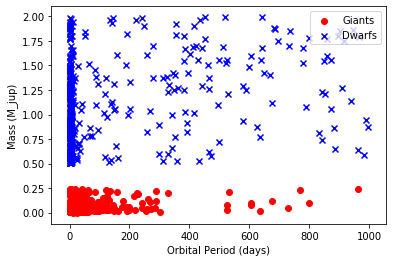

In [3]:
# plot data

#print(y[539:])
plt.scatter(x=X[:540, 0], y=X[:540, 1],
            color='red', marker='o', label='Giants')
plt.scatter(x=X[540:, 0], y=X[540:, 1],
            color='blue', marker='x', label='Dwarfs')

plt.xlabel('Orbital Period (days)')
plt.ylabel('Mass (M_jup)')
plt.legend(loc='upper right')

plt.show()

## Pipelines (for classifiers) and k-fold cross-validation

In [4]:
pipe1 = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True))

pipe2 = make_pipeline(DecisionTreeClassifier(max_depth=4,
                                             criterion='entropy',
                                             random_state=0))

pipe3 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=25,
                                                             p=3,
                                                             metric='minkowski'))

clf_labels = ['SVC', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='accuracy')
    print("Accuracy: " + str(round(scores.mean(), 2)) + 
          " Stdev: " + str(round(scores.std(), 3)) +
          " [" + label + "]")

10-fold cross validation:

Accuracy: 1.0 Stdev: 0.004 [SVC]
Accuracy: 1.0 Stdev: 0.0 [Decision tree]
Accuracy: 0.99 Stdev: 0.011 [KNN]


## Ensemble

In [5]:
from sklearn.ensemble import VotingClassifier

mv_clf = VotingClassifier(estimators=[('p', pipe1), ('dt', pipe2), ('kn', pipe3)])

clf_labels += ['Majority voting']
all_clf = [pipe1, pipe2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='accuracy')
    print("Accuracy: " + str(round(scores.mean(), 2)) + 
          " Stdev: " + str(round(scores.std(), 3)) +
          " [" + label + "]")

Accuracy: 1.0 Stdev: 0.004 [SVC]
Accuracy: 1.0 Stdev: 0.0 [Decision tree]
Accuracy: 0.99 Stdev: 0.011 [KNN]
Accuracy: 1.0 Stdev: 0.004 [Majority voting]


## Performance on Testing Sets

In [6]:
pipe1.fit(X_train, y_train)

y_pred = pipe1.predict(X_test)
print('Misclassified test set examples:', (y_test != y_pred).sum())
print('Out of a total of:', y_test.shape[0])
print('Accuracy:', pipe1.score(X_test, y_test))

Misclassified test set examples: 0
Out of a total of: 295
Accuracy: 1.0


In [7]:
pipe2.fit(X_train, y_train)

y_pred = pipe2.predict(X_test)
print('Misclassified test set examples:', (y_test != y_pred).sum())
print('Out of a total of:', y_test.shape[0])
print('Accuracy:', pipe2.score(X_test, y_test))

Misclassified test set examples: 0
Out of a total of: 295
Accuracy: 1.0


In [8]:
pipe3.fit(X_train, y_train)

y_pred = pipe3.predict(X_test)
print('Misclassified test set examples:', (y_test != y_pred).sum())
print('Out of a total of:', y_test.shape[0])
print('Accuracy:', pipe3.score(X_test, y_test))

Misclassified test set examples: 2
Out of a total of: 295
Accuracy: 0.9932203389830508


In [9]:
mv_clf.fit(X_train, y_train)

y_pred = mv_clf.predict(X_test)
print('Misclassified test set examples:', (y_test != y_pred).sum())
print('Out of a total of:', y_test.shape[0])
print('Accuracy:', mv_clf.score(X_test, y_test))

Misclassified test set examples: 0
Out of a total of: 295
Accuracy: 1.0


## Results Summary
* **Cross-Validation**

The cross-validation results indicate very high accuracy from all the classifiers and the majority voting ensemble. SVC, Decision Tree, and the Ensemble all obtained 100% accuracy and KNN achieved 99% accuracy. All standard deviations were < 0.02. 

* **Performance on testing data**

With regards to accuracy, the results of testing on the testing data are consistent with those of cross-validation. All exhibited >98% accuracy, with only KNN misclassifying 2 test set examples. All other pipelines classified all test set examples correctly. 